In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input
import matplotlib.pyplot as plt

In [2]:

# Đọc dữ liệu
df = pd.read_csv('Heating Oil.csv').dropna()

# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Date' thành kiểu dữ liệu datetime
df['Date'] = pd.to_datetime(df['Date'])


# Sắp xếp dữ liệu theo ngày
df.sort_values(by='Date', inplace=True)

# Chuyển đổi cột 'Vol.' thành số
# Chuyển đổi cột 'Change %' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    else:
        return volume_str

def convert_change_to_number(change):
    try:
        return float(change.strip('%'))
    except AttributeError:
        return change

df['Vol.'] = df['Vol.'].apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)

# Tạo dữ liệu giả cho các ngày cuối tuần thiếu
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Kiểm tra xem ngày đó có trong dữ liệu không
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Kiểm tra DataFrame có dữ liệu không
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Tính toán giá trị trung bình của các cột (trừ cột 'Date')
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Tạo một Series mới với ngày và giá trị mới
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Thêm dòng dữ liệu vào DataFrame mới
                weekend_data.loc[len(weekend_data)] = new_row

    # Kết hợp dữ liệu gốc và dữ liệu cuối tuần giả mạo
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Áp dụng hàm để điền giá trị cho các ngày cuối tuần
df = fill_missing_weekends(df)

In [3]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-03-01 00:00:00,2.001,2.0293,2.0479,1.9791,55010,-1.11
1,2019-03-02 00:00:00,2.00765,2.0146,2.0428,1.98875,55530.0,-0.225
2,2019-03-03 00:00:00,2.00765,2.0146,2.0428,1.98875,55530.0,-0.225
3,2019-03-04 00:00:00,2.0143,1.9999,2.0377,1.9984,56050,0.66
4,2019-03-05 00:00:00,2.0164,2.011,2.0229,1.9909,45160,0.1
...,...,...,...,...,...,...,...
1914,2024-05-27 00:00:00,2.4393,2.41615,2.4551,2.4014,25415.0,0.32
1915,2024-05-28 00:00:00,2.465,2.4148,2.48,2.4131,28960,0.57
1916,2024-05-29 00:00:00,2.437,2.4801,2.4935,2.4295,22870,-1.14
1917,2024-05-30 00:00:00,2.3694,2.4305,2.4368,2.3637,18120,-2.77


In [4]:

df = df.dropna()
df = df.reset_index(drop=True)


In [5]:
price = df['Price'].values
price = price.reshape(-1, 1)

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

# Heating Oil


## 7:3

In [7]:
train_size = int(len(price_scaled) * 0.7)
test_size = int(len(price_scaled) * 0.3)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]

In [8]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [9]:
look_back = 20
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [10]:
# Xây dựng mô hình LSTM
model = Sequential()
model.add(Input(shape=(look_back, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [11]:
# Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0668
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0036
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0020
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0016
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0016
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0015
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0014
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0015
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0015
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0013
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0014
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0015
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0015
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0013
Epoch 15/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - lo

In [12]:

# Dự báo
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


In [13]:
# Tính toán RMSE, MAPE và MAE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test, test_predict))
test_score_mape = mean_absolute_percentage_error(Y_test, test_predict) * 100
test_score_mae = mean_absolute_error(Y_test, test_predict)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MAE trên tập test là:', test_score_mae)

RMSE trên tập test là: 0.06057017596339882
MAPE trên tập test là: 1.700555093281573 %
MAE trên tập test là: 0.047448563535535664


In [14]:
# Dự báo giá trị 90 ngày trong tương lai
last_20_days = price_scaled[-look_back:]
next_90_days = []

for i in range(90):
    x = last_20_days[-look_back:].reshape(1, look_back, 1)
    y_hat = model.predict(x)
    next_90_days.append(y_hat)
    last_20_days = np.append(last_20_days, y_hat, axis=0)

next_90_days = np.array(next_90_days).reshape(-1, 1)
next_90_days = scaler.inverse_transform(next_90_days)

print("Dự báo giá trị 90 ngày trong tương lai:")
print(next_90_days)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

In [15]:

test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index


next_90_days_df = pd.DataFrame(next_90_days)

next_90_index = range(len(df), len(df)+len(next_90_days))
next_90_days_df.index = next_90_index

train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]
next_90_days_df

,0
1919,2.341373
1920,2.312677
1921,2.286046
1922,2.260047
1923,2.234663
...,...
2004,1.005519
2005,1.001042
2006,0.996727
2007,0.992567


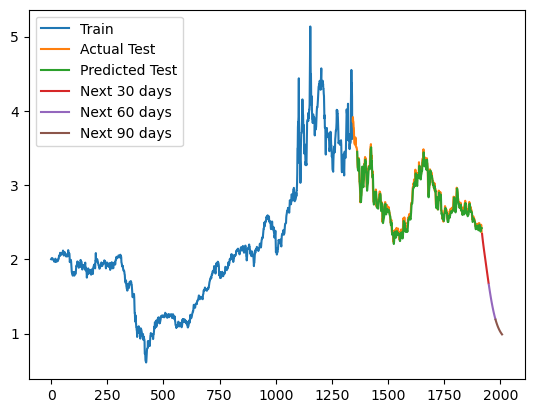

In [16]:
next_30_days_plt = next_90_days_df[:30]
next_60_days_plt = next_90_days_df[30:60]
next_90_days_plt = next_90_days_df[60:]
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_plt, label='Next 30 days')
plt.plot(next_60_days_plt, label='Next 60 days')
plt.plot(next_90_days_plt, label='Next 90 days')
plt.savefig("LSTM_Heating_Oil_Week6.png")
plt.legend()
plt.show()

## 8:2

In [17]:
train_size = int(len(price_scaled) * 0.8)
test_size = int(len(price_scaled) * 0.2)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]

In [18]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [19]:
look_back = 20
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [20]:
# Xây dựng mô hình LSTM
model = Sequential()
model.add(Input(shape=(look_back, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [21]:
# Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.0743
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0038
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0016
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0015
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0015
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0016
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0017
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0015
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0015
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0016
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0015
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0013
Epoch 13/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0017
Epoch 14/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0015
Epoch 15/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - lo

In [22]:

# Dự báo
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


In [23]:
# Tính toán RMSE, MAPE và MAE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test, test_predict))
test_score_mape = mean_absolute_percentage_error(Y_test, test_predict) * 100
test_score_mae = mean_absolute_error(Y_test, test_predict)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MAE trên tập test là:', test_score_mae)

RMSE trên tập test là: 0.05555596115669176
MAPE trên tập test là: 1.5329154160984917 %
MAE trên tập test là: 0.0429004715312611


In [24]:
# Dự báo giá trị 90 ngày trong tương lai
last_20_days = price_scaled[-look_back:]
next_90_days = []

for i in range(90):
    x = last_20_days[-look_back:].reshape(1, look_back, 1)
    y_hat = model.predict(x)
    next_90_days.append(y_hat)
    last_20_days = np.append(last_20_days, y_hat, axis=0)

next_90_days = np.array(next_90_days).reshape(-1, 1)
next_90_days = scaler.inverse_transform(next_90_days)

print("Dự báo giá trị 90 ngày trong tương lai:")
print(next_90_days)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━

In [25]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index


next_90_days_df = pd.DataFrame(next_90_days)

next_90_index = range(len(df), len(df)+len(next_90_days))
next_90_days_df.index = next_90_index

train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]
next_90_days_df

,0
1919,2.335316
1920,2.311418
1921,2.287686
1922,2.264320
1923,2.241785
...,...
2004,1.406099
2005,1.401471
2006,1.396926
2007,1.392462


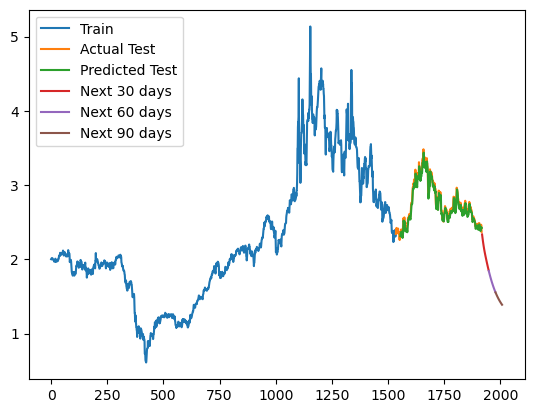

In [26]:
next_30_days_plt = next_90_days_df[:30]
next_60_days_plt = next_90_days_df[30:60]
next_90_days_plt = next_90_days_df[60:]
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_plt, label='Next 30 days')
plt.plot(next_60_days_plt, label='Next 60 days')
plt.plot(next_90_days_plt, label='Next 90 days')
#plt.savefig("LSTM_Cruide_Oil_Week6.png")
plt.legend()
plt.show()

## 9:1

In [27]:
train_size = int(len(price_scaled) * 0.9)
test_size = int(len(price_scaled) * 0.1)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:train_size+test_size]

In [28]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i + look_back, 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [29]:
look_back = 20
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [30]:
# Xây dựng mô hình LSTM
model = Sequential()
model.add(Input(shape=(look_back, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [31]:
# Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0719
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0038
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0016
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0016
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0016
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0015
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0015
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0015
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0014
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0013
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0011
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0016
Epoch 13/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0016
Epoch 14/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0014
Epoch 15/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - lo

In [32]:

# Dự báo
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step


In [33]:
# Tính toán RMSE, MAPE và MAE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(Y_test, test_predict))
test_score_mape = mean_absolute_percentage_error(Y_test, test_predict) * 100
test_score_mae = mean_absolute_error(Y_test, test_predict)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MAE trên tập test là:', test_score_mae)

RMSE trên tập test là: 0.06739346405156492
MAPE trên tập test là: 2.261512670069064 %
MAE trên tập test là: 0.059896783518651756


In [34]:
# Dự báo giá trị 90 ngày trong tương lai
last_20_days = price_scaled[-look_back:]
next_90_days = []

for i in range(90):
    x = last_20_days[-look_back:].reshape(1, look_back, 1)
    y_hat = model.predict(x)
    next_90_days.append(y_hat)
    last_20_days = np.append(last_20_days, y_hat, axis=0)

next_90_days = np.array(next_90_days).reshape(-1, 1)
next_90_days = scaler.inverse_transform(next_90_days)

print("Dự báo giá trị 90 ngày trong tương lai:")
print(next_90_days)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

In [35]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+look_back, len(train_data)+look_back+len(test_predict))
test_predict_df.index = test_predict_index


next_90_days_df = pd.DataFrame(next_90_days)

next_90_index = range(len(df), len(df)+len(next_90_days))
next_90_days_df.index = next_90_index

train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]
next_90_days_df

,0
1919,2.308667
1920,2.264040
1921,2.216527
1922,2.168488
1923,2.120624
...,...
2004,1.006148
2005,1.003999
2006,1.001920
2007,0.999907


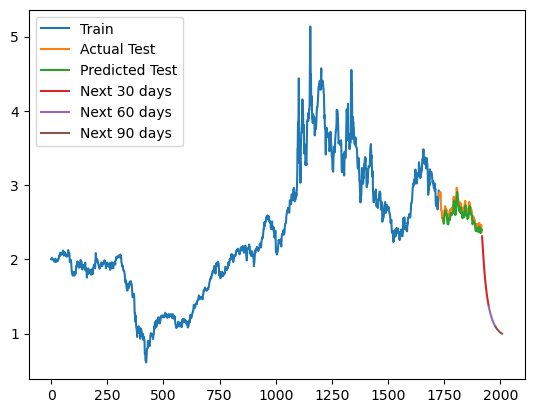

In [36]:
next_30_days_plt = next_90_days_df[:30]
next_60_days_plt = next_90_days_df[30:60]
next_90_days_plt = next_90_days_df[60:]
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_30_days_plt, label='Next 30 days')
plt.plot(next_60_days_plt, label='Next 60 days')
plt.plot(next_90_days_plt, label='Next 90 days')
#plt.savefig("LSTM_Cruide_Oil_Week6.png")
plt.legend()
plt.show()